## Real or Not? NLP with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not

In [354]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re
from nltk.corpus import stopwords
import nlppreprocess
from nlppreprocess import NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_score, recall_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV, train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize,RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, sgd, rmsprop
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler


In [355]:
import os

TWITTER_PATH = os.path.join("datasets", "TwitterData")

In [356]:
def load_twitter_data(filename, twitter_path = TWITTER_PATH):
    csv_path = os.path.join(twitter_path, filename)
    return pd.read_csv(csv_path)

In [357]:
train_data = load_twitter_data('train.csv')
test_data = load_twitter_data('test.csv')

In [358]:
len(train_data)

7613

In [359]:
len(test_data)

3263

In [360]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [361]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [362]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [363]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [364]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [365]:
train_data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [366]:
s = (train_data.dtypes == 'object')
object_cols = list(s[s].index)
print("categorical attributes")
print(object_cols)

categorical attributes
['keyword', 'location', 'text']


### Percentage of missing values in training data

In [367]:
train_data_percent_missing = train_data.isnull().mean()*100
percent_missing_train = pd.DataFrame({"Training data missing percentage": train_data_percent_missing.sort_values(ascending = False)})
percent_missing_train

,Training data missing percentage
location,33.272035
keyword,0.801261
target,0.000000
text,0.000000
id,0.000000


### Percentage of missing values in test data

In [368]:
test_data_percent_missing = test_data.isnull().mean()*100
percent_missing_test = pd.DataFrame({'Test data missing percentage': test_data_percent_missing.sort_values(ascending = False)})
percent_missing_test

,Test data missing percentage
location,33.864542
keyword,0.796813
text,0.000000
id,0.000000


### lets view some of non-disastrous tweets (target = 0)

In [369]:
non_disastrous = train_data[train_data['target']==0]['text']
non_disastrous.head(10)

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object

### lets view some of disastrous tweets (target = 1)

In [370]:
disastrous = train_data[train_data['target']==1]['text']
disastrous.head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [371]:
train_data['location'].value_counts()

USA                      104
New York                  71
United States             50
London                    45
Canada                    29
                        ... 
teh internets              1
#Bummerville otw           1
Waialua, Hawaii            1
PARACHUTE                  1
Guelph Ontario Canada      1
Name: location, Length: 3341, dtype: int64

In [372]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Non disastrous vs disastrous tweets

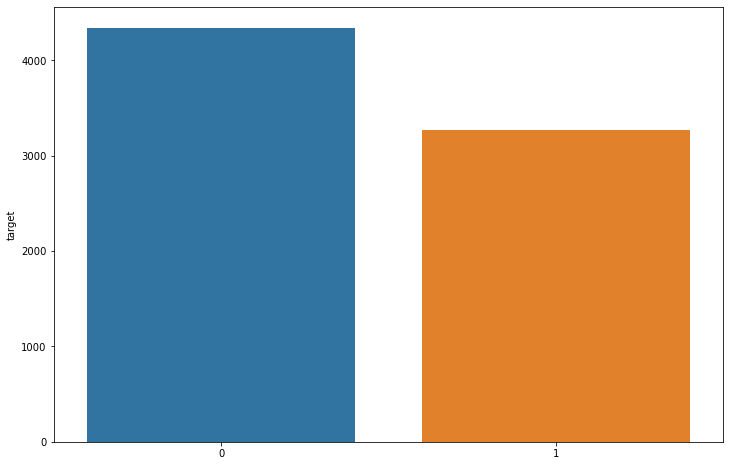

In [373]:
plt.figure(figsize = (12,8))
sns.barplot(train_data['target'].value_counts().index, train_data['target'].value_counts())

### Unique values in keyword feature

In [374]:
train_data.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [375]:
train_data['keyword'].nunique()

221

### plotting first 50 most common keywords

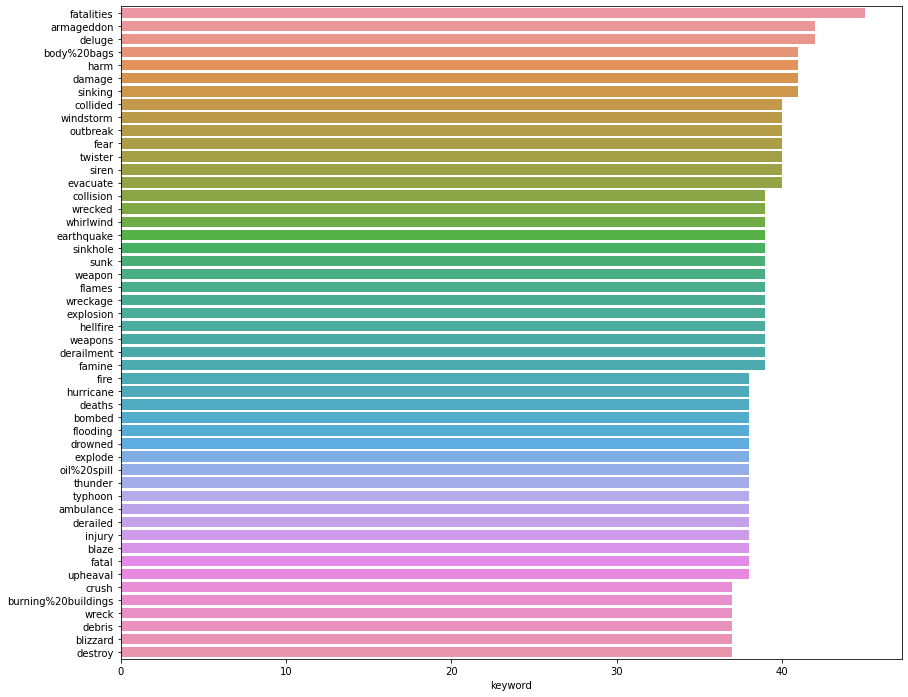

In [376]:
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train_data['keyword'].value_counts().index[:50], x=train_data['keyword'].value_counts()[:50])

### Analyze location feature

In [377]:
train_data['location'].value_counts()

USA                      104
New York                  71
United States             50
London                    45
Canada                    29
                        ... 
teh internets              1
#Bummerville otw           1
Waialua, Hawaii            1
PARACHUTE                  1
Guelph Ontario Canada      1
Name: location, Length: 3341, dtype: int64

In [378]:
train_data['location'].nunique()

3341

### lets view first 50 most common locations

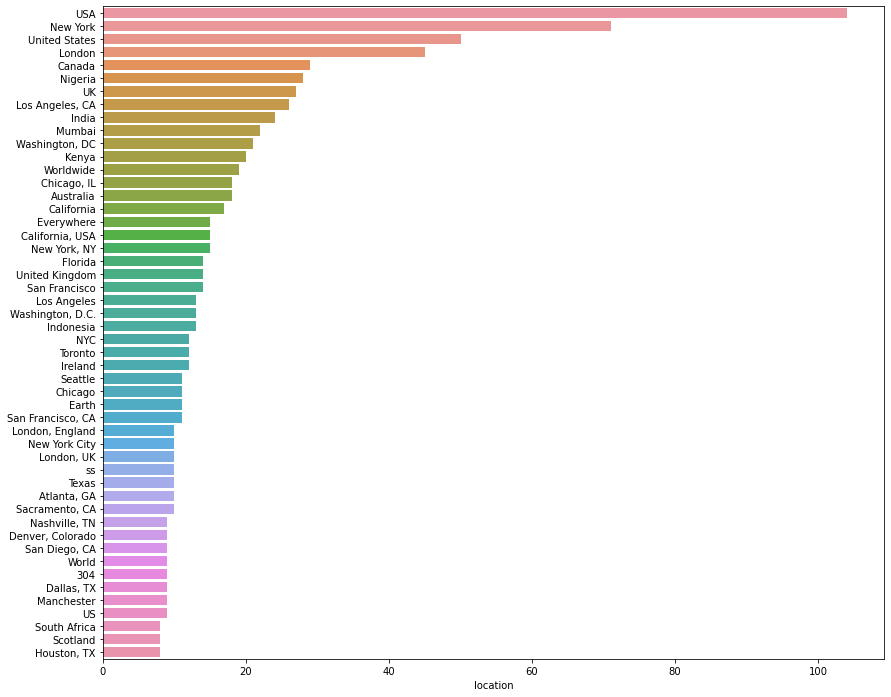

In [379]:
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train_data['location'].value_counts().index[:50], x=train_data['location'].value_counts()[:50])

### lets view last 50 least common locations

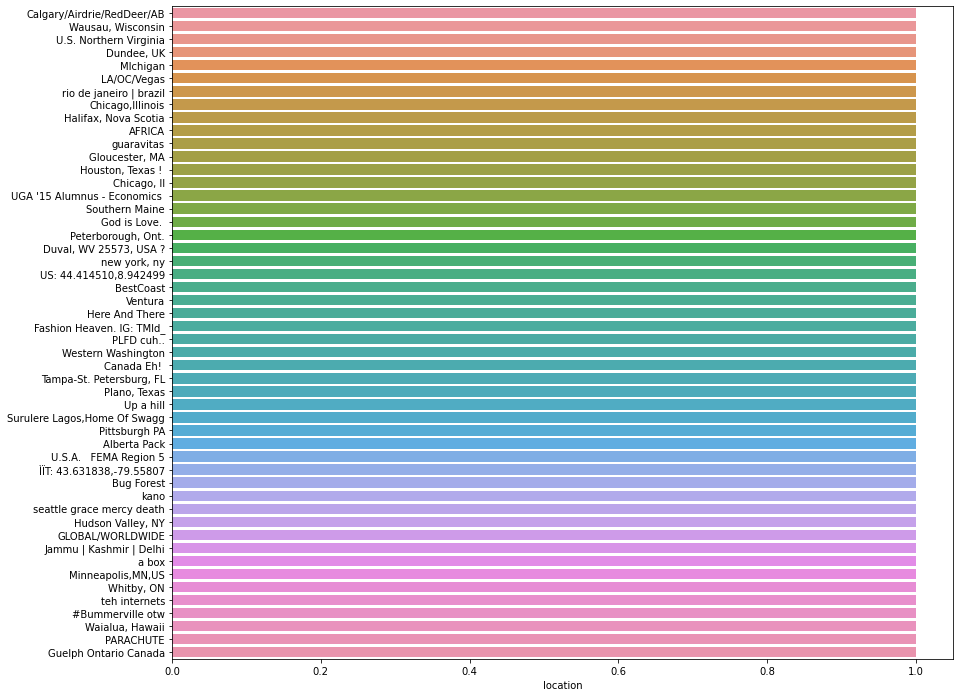

In [380]:
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train_data['location'].value_counts().index[-50:], x=train_data['location'].value_counts()[-50:])

### Since location feature has missing values and droping this feature does not affect the target

In [381]:
train = train_data.drop(['target', 'location'], axis = 1)
test = test_data.drop('location', axis = 1)

### Add a new feature 'text_length'

In [382]:
train['text_length'] = train_data['text'].apply(lambda x:len(x))
test['text_length'] = test_data['text'].apply(lambda x:len(x))

In [383]:
train.head()

,id,keyword,text,text_length
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,69
1,4,NaN,Forest fire near La Ronge Sask. Canada,38
2,5,NaN,All residents asked to 'shelter in place' are ...,133
3,6,NaN,"13,000 people receive #wildfires evacuation or...",65
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,88


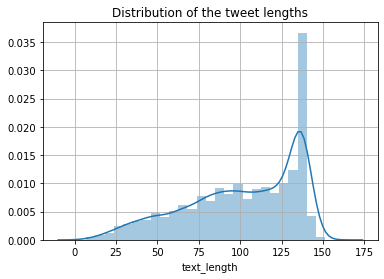

In [384]:
#Create distribution chart to visualize text length distribution
ax=sns.distplot(train['text_length']).set_title('Distribution of the tweet lengths');
plt.grid(True)

In [385]:
test.head()

,id,keyword,text,text_length
0,0,NaN,Just happened a terrible car crash,34
1,2,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45


In [386]:
y_train = train_data['target'].copy()

## 2. Text Processing

### Convert every word in a sentence to lower case and remove noise (html tags, punctuation, symbols, etc

In [387]:
def lowercase_text(text):
    text = text.lower()
    return text

In [388]:
train['text'] = train['text'].apply(lambda x: lowercase_text(x))
test['text'] = test['text'].apply(lambda x: lowercase_text(x))

In [389]:
train.head()

,id,keyword,text,text_length
0,1,NaN,our deeds are the reason of this #earthquake m...,69
1,4,NaN,forest fire near la ronge sask. canada,38
2,5,NaN,all residents asked to 'shelter in place' are ...,133
3,6,NaN,"13,000 people receive #wildfires evacuation or...",65
4,7,NaN,just got sent this photo from ruby #alaska as ...,88


In [390]:
test.head()

,id,keyword,text,text_length
0,0,NaN,just happened a terrible car crash,34
1,2,NaN,"heard about #earthquake is different cities, s...",64
2,3,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,apocalypse lighting. #spokane #wildfires,40
4,11,NaN,typhoon soudelor kills 28 in china and taiwan,45


In [391]:
def remove_noise(text):
    text = re.sub('\[.*?\]','', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [392]:
train['text'] = train['text'].apply(lambda x: remove_noise(x))
test['text'] = test['text'].apply(lambda x: remove_noise(x))

In [393]:
train.head(5)

,id,keyword,text,text_length
0,1,NaN,our deeds are the reason of this earthquake ma...,69
1,4,NaN,forest fire near la ronge sask canada,38
2,5,NaN,all residents asked to shelter in place are be...,133
3,6,NaN,people receive wildfires evacuation orders in...,65
4,7,NaN,just got sent this photo from ruby alaska as s...,88


In [394]:
test.head()

,id,keyword,text,text_length
0,0,NaN,just happened a terrible car crash,34
1,2,NaN,heard about earthquake is different cities sta...,64
2,3,NaN,there is a forest fire at spot pond geese are ...,96
3,9,NaN,apocalypse lighting spokane wildfires,40
4,11,NaN,typhoon soudelor kills in china and taiwan,45


In [395]:
def pre_process_text_combined(text):
    
    """
    Input- text= text to be pre-processed
    
    Oputput- return cleaned and combined text to be vectrorized for Machine learning.

    """
    #Initiate a tokenizer
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(text)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return  combined_text

In [396]:
train['text'] = train['text'].apply(lambda x: pre_process_text_combined(x))

In [397]:
train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [398]:
test['text'] = test['text'].apply(lambda x: pre_process_text_combined(x))

In [399]:
test['text'].head()

0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4                  typhoon soudelor kills china taiwan
Name: text, dtype: object

### Removing emojis

In [400]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [401]:
train['text'] = train['text'].apply(lambda x: remove_emoji(x))

In [402]:
train.text.values

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'volcano hawaii',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
       'latest homes razed northern california wildfire abc news'],
      dtype=object)

In [403]:
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

In [404]:
test.text.values

array(['happened terrible car crash',
       'heard earthquake different cities stay safe everyone',
       'forest fire spot pond geese fleeing across street cannot save',
       ..., 'green line derailment chicago',
       'meg issues hazardous weather outlook hwo',
       'cityofcalgary activated municipal emergency plan yycstorm'],
      dtype=object)

In [405]:
def clean(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    
    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    return tweet


train['text'] = train['text'].apply(clean)
test['text'] = test['text'].apply(clean)

In [53]:
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word', binary=True)

train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

# Printing first vector
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [54]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

### SVC

In [237]:
svm_clf = SVC()
svm_clf.fit(train_vectors, y_train)

SVC()

In [238]:
from sklearn.model_selection import cross_val_score

scores_svc = cross_val_score(svm_clf, train_vectors, y_train, scoring = "f1", cv = 5)
scores_svc

array([0.56329114, 0.45373134, 0.53745318, 0.48172043, 0.67579909])

### Logistic Regression

In [239]:
log_reg = LogisticRegression(C=1.0)
log_reg.fit(train_vectors, y_train)

LogisticRegression()

In [240]:
scores_logreg = cross_val_score(log_reg, train_vectors, y_train, scoring = "f1", cv = 5)
scores_logreg

array([0.61274976, 0.49480969, 0.57692308, 0.53639847, 0.68904876])

### DecisionTreeClassifier

In [241]:
dectree_clf = DecisionTreeClassifier()
dectree_clf.fit(train_vectors, y_train)

DecisionTreeClassifier()

In [242]:
scores_dectree = cross_val_score(dectree_clf, train_vectors, y_train, scoring = "f1", cv = 5)
scores_dectree

array([0.53577982, 0.44389844, 0.53783982, 0.45422535, 0.6143695 ])

### RandomForestClassifier

In [243]:
rand_frst = RandomForestClassifier()
rand_frst.fit(train_vectors, y_train)

RandomForestClassifier()

In [244]:
scores_randfrst = cross_val_score(rand_frst, train_vectors, y_train, scoring = "f1", cv = 5)
scores_randfrst

array([0.55366098, 0.42702703, 0.54589372, 0.45507812, 0.65712013])

### KNeighbors

In [249]:
kneighbor = KNeighborsClassifier(n_neighbors=10)
kneighbor.fit(train_vectors, y_train)

KNeighborsClassifier(n_neighbors=10)

In [250]:
scores_kneighbor = cross_val_score(kneighbor, train_vectors, y_train, scoring = "f1", cv = 5)
scores_kneighbor

array([0.07058824, 0.03598201, 0.02105263, 0.04179104, 0.08211144])

### xgb

In [251]:
import xgboost as xb
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(train_vectors, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [252]:
scores_xgb = cross_val_score(xgb, train_vectors, y_train, scoring = "f1", cv = 5)
scores_xgb

array([0.50790306, 0.38606403, 0.45921986, 0.36479321, 0.50895382])

### BaggingClassifier

In [253]:
from sklearn.ensemble import BaggingClassifier

bagg = BaggingClassifier()
bagg.fit(train_vectors, y_train)

BaggingClassifier()

In [254]:
scores_bagg = cross_val_score(bagg, train_vectors, y_train, scoring = "f1", cv = 5)
scores_bagg

array([0.56504854, 0.36678832, 0.52131939, 0.43656716, 0.52033898])

### AdaBoostClassifier

In [255]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(train_vectors, y_train)

AdaBoostClassifier()

In [256]:
scores_ada = cross_val_score(ada, train_vectors, y_train, scoring = "f1", cv = 5)
scores_ada

array([0.48085106, 0.41082164, 0.41642789, 0.38219327, 0.51464435])

### MultinomialNB (using this model able to reach top 37% position on leaderboard, Kaggle)

In [261]:
mnb = MultinomialNB(alpha=1)
mnb.fit(train_vectors, y_train)

MultinomialNB(alpha=1)

In [262]:
scores_mnb = cross_val_score(mnb, train_vectors, y_train, scoring = "f1", cv = 5)
scores_mnb

array([0.635     , 0.6116643 , 0.68188302, 0.640553  , 0.72380952])

In [273]:
mnb.fit(train_tfidf, y_train)

MultinomialNB(alpha=1)

In [274]:
scores_tfidf = cross_val_score(mnb, train_tfidf, y_train, scoring = "f1", cv = 5)
scores_tfidf

array([0.57198825, 0.57192982, 0.61498258, 0.59019426, 0.73878205])

### grid search logistic regression

In [258]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

hyperparams = {'penalty': penalty, 'C': C}

gd1 = GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "f1", n_jobs=-1)

gd1.fit(train_vectors, y_train)
print(gd1.best_score_)
print(gd1.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    5.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished


0.59072426064039
{'C': 10000.0, 'penalty': 'l2'}


c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Grid search for AdaBoostClassifier

In [260]:
n_estimators = [10, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

gd2=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "f1", n_jobs=-1)

gd2.fit(train_vectors, y_train)
print(gd2.best_score_)
print(gd2.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 13.8min finished


0.5297673302743737
{'learning_rate': 1, 'n_estimators': 500}


### Grid search for gradient boosting

In [280]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
n_estimators = [100, 1000, 2000]
max_depth = [3, 5, 10, 15]

hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

gd3=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "f1", n_jobs=-1)

gd3.fit(train_vectors, y_train)
print(gd3.best_score_)
print(gd3.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 20.6min finished


0.5120235594168945
{'learning_rate': 0.5, 'n_estimators': 1000}


### Grid search for SVC

In [277]:
param_grid = {'C': [0.1, 1, 5, 10, 15, 20],  
              'gamma': [0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf', 'poly']} 
svm_grid_clf = SVC()
gd4 = GridSearchCV(svm_grid_clf, param_grid, refit = True, scoring = 'f1', verbose = 2)
gd4.fit(train_vectors, y_train)
print(gd4.best_score_)
print(gd4.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] C=0.1, gamma=0.1, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   6.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   5.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   6.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   5.6s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   5.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   8.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   7.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   8.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 40.6min finished


0.5793570955160725
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


### Grid search for RandomForest

In [281]:
n_estimators = [10, 50, 100, 200]
max_depth = [2, 3]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 6]
min_samples_leaf = [2, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd6=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "f1", n_jobs=-1)

gd6.fit(train_vectors, y_train)
print(gd6.best_score_)
print(gd6.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min


0.19246646486069782
{'max_depth': 3, 'max_features': 0.1, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  7.8min finished


## Tensorflow and keras model

In [406]:
train_tweets = train.text.values
test_tweets = test.text.values
train_target = train_data.target.values

In [407]:
train_tweets.shape

(7613,)

In [408]:
test_tweets.shape

(3263,)

In [409]:
train_target.shape

(7613,)

In [410]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

16420

In [411]:
def metrics_analyze(pred_target, y_test):
    print("F1-score: ", f1_score(pred_target, y_test))
    print("Precision: ", precision_score(pred_target, y_test))
    print("Recall: ", recall_score(pred_target, y_test))
    print("Acuracy: ", accuracy_score(pred_target, y_test))
    print("-"*50)
    print(classification_report(pred_target, y_test))

In [412]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [413]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' +string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' +string])
    plt.show()

In [414]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mahesh Kumar M
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [415]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
train_padded_sentences1 = pad_sequences(embed(train_tweets), length_long_sentence, padding='post')
test_padded_sentences1 = pad_sequences(embed(test_tweets), length_long_sentence, padding='post')

In [416]:
embeddings_dictionary = dict()
embedding_dim = 200
glove_file = open('glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [417]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [418]:
embedding_matrix.shape

(16420, 200)

In [419]:
X_train, X_test, y_train, y_test = train_test_split(train_padded_sentences1, train_target, test_size=0.20)

In [420]:
X_train.shape

(6090, 23)

In [421]:
X_test.shape

(1523, 23)

### model1

In [422]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length = length_long_sentence),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(length_long_sentence, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [423]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 23, 200)           3284000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 4600)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 23)                105823    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 24        
Total params: 3,389,847
Trainable params: 3,389,847
Non-trainable params: 0
_________________________________________________________________


In [424]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [425]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [426]:
num_epochs = 30
history1 = model1.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.5921 - accuracy: 0.6928 - val_loss: 0.4556 - val_accuracy: 0.8037
Epoch 2/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.2548 - accuracy: 0.9064 - val_loss: 0.4949 - val_accuracy: 0.7768
Epoch 3/30
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.0938 - accuracy: 0.9703 - val_loss: 0.5665 - val_accuracy: 0.7630
Epoch 4/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.0668 - accuracy: 0.9767 - val_loss: 0.5798 - val_accuracy: 0.7761
Epoch 5/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.0554 - accuracy: 0.9787 - val_loss: 0.5878 - val_accuracy: 0.7846
Epoch 6/30
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.0474 - accuracy: 0.9821 - val_loss: 0.6089 - val_accuracy: 0.7649
Epoch 7/30
6090/6090 [==============================] - 11s 2ms/sample

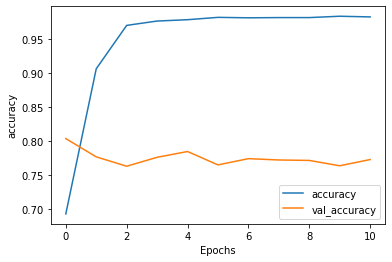

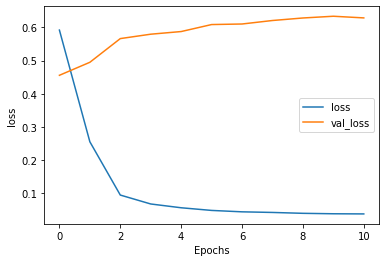

In [427]:
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

In [428]:
preds1 = model1.predict_classes(X_test)

In [429]:
metrics_analyze(preds1, y_test)

F1-score:  0.7518672199170124
Precision:  0.6751117734724292
Recall:  0.848314606741573
Acuracy:  0.8036769533814839
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       989
           1       0.68      0.85      0.75       534

    accuracy                           0.80      1523
   macro avg       0.79      0.81      0.79      1523
weighted avg       0.82      0.80      0.81      1523



### Model 2

In [430]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length = length_long_sentence),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(length_long_sentence, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [431]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 23, 200)           3284000   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 23)                4623      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 24        
Total params: 3,288,647
Trainable params: 3,288,647
Non-trainable params: 0
_________________________________________________________________


In [432]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [433]:
num_epochs = 30
history2 = model2.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.6139 - accuracy: 0.6593 - val_loss: 0.4756 - val_accuracy: 0.7991
Epoch 2/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.3565 - accuracy: 0.8540 - val_loss: 0.4398 - val_accuracy: 0.8083
Epoch 3/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.2219 - accuracy: 0.9200 - val_loss: 0.4736 - val_accuracy: 0.7965
Epoch 4/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.1443 - accuracy: 0.9519 - val_loss: 0.5397 - val_accuracy: 0.7951
Epoch 5/30
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.1020 - accuracy: 0.9655 - val_loss: 0.5919 - val_accuracy: 0.7761
Epoch 6/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.0783 - accuracy: 0.9721 - val_loss: 0.6479 - val_accuracy: 0.7807
Epoch 7/30
6090/6090 [==============================] - 10s 2ms/sample

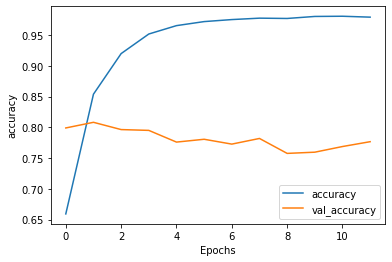

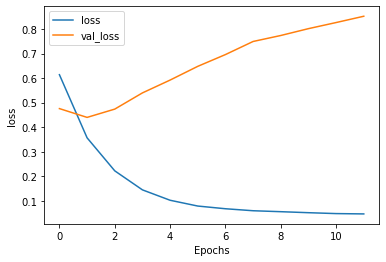

In [434]:
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

In [435]:
preds2 = model2.predict_classes(X_test)

In [436]:
metrics_analyze(preds2, y_test)

F1-score:  0.7582781456953642
Precision:  0.6825633383010432
Recall:  0.8528864059590316
Acuracy:  0.8082731451083388
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       986
           1       0.68      0.85      0.76       537

    accuracy                           0.81      1523
   macro avg       0.79      0.82      0.80      1523
weighted avg       0.83      0.81      0.81      1523



### Model 3 best model (without stemming, lemmatize)(using this model, i am able to reach top 31% position on leaderboard, Kaggle)

In [262]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization

In [249]:
model3 = Sequential()
embedding_layer = Embedding(vocab_length, embedding_dim, weights = [embedding_matrix], input_length = length_long_sentence, trainable = False)
model3.add(embedding_layer)
model3.add(Bidirectional(LSTM(64, return_sequences = True)))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

In [190]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 200)           3287000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 23, 128)           135680    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 3,468,121
Trainable params: 181,121
Non-trainable params: 3,287,000
_________________________________________________________________


In [191]:
adam = tf.keras.optimizers.Adam(lr = 0.01)
model3.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [192]:
history3 = model3.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 6s 1ms/step - loss: 0.4887 - accuracy: 0.7839 - val_loss: 0.4505 - val_accuracy: 0.7965
Epoch 2/30
6090/6090 [==============================] - 5s 822us/step - loss: 0.4213 - accuracy: 0.8225 - val_loss: 0.4330 - val_accuracy: 0.8155
Epoch 3/30
6090/6090 [==============================] - 5s 868us/step - loss: 0.3448 - accuracy: 0.8568 - val_loss: 0.4486 - val_accuracy: 0.8122
Epoch 4/30
6090/6090 [==============================] - 5s 882us/step - loss: 0.2863 - accuracy: 0.8798 - val_loss: 0.4992 - val_accuracy: 0.8050
Epoch 5/30
6090/6090 [==============================] - 5s 864us/step - loss: 0.2243 - accuracy: 0.9071 - val_loss: 0.5547 - val_accuracy: 0.7997
Epoch 6/30
6090/6090 [==============================] - 5s 860us/step - loss: 0.1843 - accuracy: 0.9240 - val_loss: 0.5732 - val_accuracy: 0.7846
Epoch 7/30
6090/6090 [==============================] - 6s 914us/step - loss: 

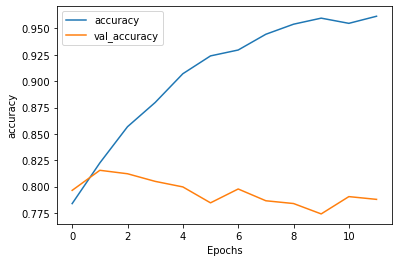

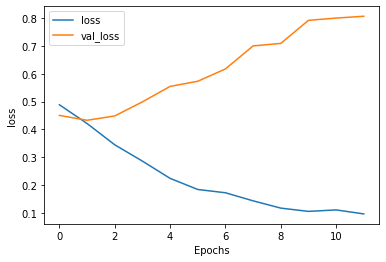

In [193]:
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

In [194]:
preds3 = model3.predict_classes(X_test)

In [195]:
metrics_analyze(preds3, y_test)

F1-score:  0.7668049792531121
Precision:  0.6936936936936937
Recall:  0.8571428571428571
Acuracy:  0.8154957321076822
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       984
           1       0.69      0.86      0.77       539

    accuracy                           0.82      1523
   macro avg       0.80      0.82      0.81      1523
weighted avg       0.83      0.82      0.82      1523



In [226]:
submission = load_twitter_data('sample_submission.csv')
submission['target'] = model3.predict_classes(test_padded_sentences1)

In [227]:
submission.to_csv("submission1.csv", index=False)

### Model 4

In [443]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length = length_long_sentence),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [444]:
model4.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 23, 200)           3284000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 23, 128)           135680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 128)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_40 (Dense)             (None, 1)               

In [445]:
adam = keras.optimizers.Adam(lr=0.01)
model4.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [200]:
history4 = model4.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 257s 42ms/sample - loss: 0.7908 - accuracy: 0.6273 - val_loss: 0.6122 - val_accuracy: 0.6724
Epoch 2/30
6090/6090 [==============================] - 251s 41ms/sample - loss: 0.3710 - accuracy: 0.8675 - val_loss: 0.6260 - val_accuracy: 0.6980
Epoch 3/30
6090/6090 [==============================] - 251s 41ms/sample - loss: 0.3023 - accuracy: 0.8947 - val_loss: 0.7479 - val_accuracy: 0.6829
Epoch 4/30
6090/6090 [==============================] - 333s 55ms/sample - loss: 0.2752 - accuracy: 0.9026 - val_loss: 0.8071 - val_accuracy: 0.7052
Epoch 5/30
6090/6090 [==============================] - 345s 57ms/sample - loss: 0.2463 - accuracy: 0.9123 - val_loss: 0.7000 - val_accuracy: 0.7052
Epoch 6/30
6090/6090 [==============================] - 350s 57ms/sample - loss: 0.2303 - accuracy: 0.9223 - val_loss: 0.8620 - val_accuracy: 0.7052
Epoch 7/30
6090/6090 [==============================] - 34

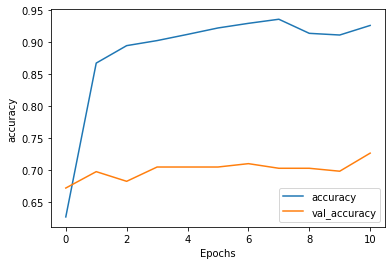

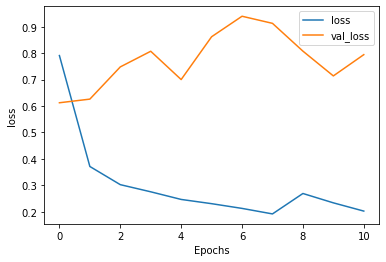

In [201]:
plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')

In [202]:
preds4 = model4.predict_classes(X_test)

In [203]:
metrics_analyze(preds4, y_test)

F1-score:  0.5141187925998052
Precision:  0.3963963963963964
Recall:  0.7313019390581718
Acuracy:  0.6723571897570584
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1162
           1       0.40      0.73      0.51       361

    accuracy                           0.67      1523
   macro avg       0.64      0.69      0.63      1523
weighted avg       0.77      0.67      0.70      1523



In [417]:
submission = load_twitter_data('sample_submission.csv')
submission['target'] = model4.predict_classes(test_padded_sentences)

In [418]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [242]:
submission.to_csv("submission.csv", index=False)

### Model 5

In [204]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length = length_long_sentence),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [205]:
model5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 23, 200)           3287000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                44928     
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 7         
Total params: 3,332,325
Trainable params: 3,332,325
Non-trainable params: 0
_________________________________________________________________


In [206]:
model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [207]:
history5 = model5.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 23s 4ms/sample - loss: 0.5886 - accuracy: 0.7043 - val_loss: 0.4767 - val_accuracy: 0.7820
Epoch 2/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.2846 - accuracy: 0.8867 - val_loss: 0.5269 - val_accuracy: 0.7689
Epoch 3/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.1349 - accuracy: 0.9552 - val_loss: 0.6644 - val_accuracy: 0.7498
Epoch 4/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.0967 - accuracy: 0.9691 - val_loss: 0.6552 - val_accuracy: 0.7590
Epoch 5/30
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.0775 - accuracy: 0.9739 - val_loss: 0.6499 - val_accuracy: 0.7590
Epoch 6/30
6090/6090 [==============================] - 17s 3ms/sample - loss: 0.0642 - accuracy: 0.9777 - val_loss: 0.7442 - val_accuracy: 0.7610
Epoch 7/30
6090/6090 [==============================] - 17s 3ms/sample

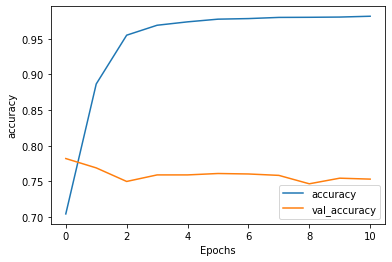

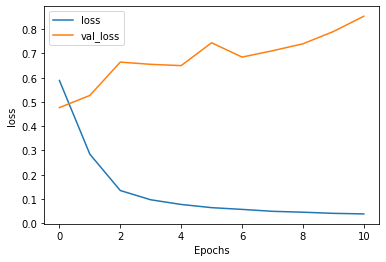

In [208]:
plot_graphs(history5, 'accuracy')
plot_graphs(history5, 'loss')

In [209]:
preds5 = model5.predict_classes(X_test)

In [211]:
metrics_analyze(preds5, y_test)

F1-score:  0.7326892109500805
Precision:  0.6831831831831832
Recall:  0.7899305555555556
Acuracy:  0.7820091923834537
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       947
           1       0.68      0.79      0.73       576

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.79      0.78      0.78      1523



### Model 6

In [212]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=length_long_sentence),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [213]:
model6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 23, 200)           3287000   
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 128)           128128    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 7         
Total params: 3,415,909
Trainable params: 3,415,909
Non-trainable params: 0
_________________________________________________________________


In [214]:
model6.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [215]:
history6 = model6.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.5622 - accuracy: 0.6956 - val_loss: 0.4530 - val_accuracy: 0.7945
Epoch 2/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.2951 - accuracy: 0.8796 - val_loss: 0.4866 - val_accuracy: 0.7866
Epoch 3/30
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.1572 - accuracy: 0.9435 - val_loss: 0.5871 - val_accuracy: 0.7728
Epoch 4/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.0946 - accuracy: 0.9681 - val_loss: 0.6641 - val_accuracy: 0.7663
Epoch 5/30
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.0686 - accuracy: 0.9739 - val_loss: 0.7415 - val_accuracy: 0.7636
Epoch 6/30
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.0546 - accuracy: 0.9785 - val_loss: 0.8754 - val_accuracy: 0.7597
Epoch 7/30
6090/6090 [==============================] - 15s 3ms/sample

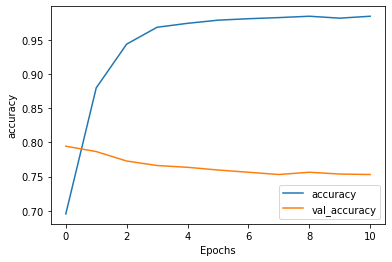

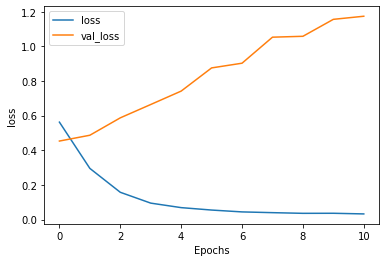

In [216]:
plot_graphs(history6, 'accuracy')
plot_graphs(history6, 'loss')

In [217]:
preds6 = model6.predict_classes(X_test)

In [219]:
metrics_analyze(preds6, y_test)

F1-score:  0.7371956339210748
Precision:  0.6591591591591591
Recall:  0.8361904761904762
Acuracy:  0.7944845699277742
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       998
           1       0.66      0.84      0.74       525

    accuracy                           0.79      1523
   macro avg       0.78      0.80      0.78      1523
weighted avg       0.82      0.79      0.80      1523



### Model 7

In [220]:
model7 = Sequential()
embedding_layer = Embedding(vocab_length, embedding_dim, weights = [embedding_matrix], input_length = length_long_sentence, trainable = False)
model7.add(embedding_layer)
model7.add(Dropout(0.2))
model7.add(Conv1D(64, 5, activation='relu'))
model7.add(MaxPooling1D(pool_size=4))
model7.add(LSTM(64))
model7.add(Dense(1, activation = 'sigmoid'))

In [221]:
model7.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [222]:
history7 = model7.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 4s 610us/step - loss: 0.4915 - accuracy: 0.7800 - val_loss: 0.4286 - val_accuracy: 0.8129
Epoch 2/30
6090/6090 [==============================] - 3s 475us/step - loss: 0.4101 - accuracy: 0.8227 - val_loss: 0.4274 - val_accuracy: 0.8083
Epoch 3/30
6090/6090 [==============================] - 3s 499us/step - loss: 0.3736 - accuracy: 0.8427 - val_loss: 0.4324 - val_accuracy: 0.8148
Epoch 4/30
6090/6090 [==============================] - 3s 491us/step - loss: 0.3196 - accuracy: 0.8722 - val_loss: 0.4470 - val_accuracy: 0.8122
Epoch 5/30
6090/6090 [==============================] - 3s 495us/step - loss: 0.2661 - accuracy: 0.8944 - val_loss: 0.4579 - val_accuracy: 0.8050
Epoch 6/30
6090/6090 [==============================] - 3s 476us/step - loss: 0.2293 - accuracy: 0.9105 - val_loss: 0.5043 - val_accuracy: 0.8011
Epoch 7/30
6090/6090 [==============================] - 3s 468us/step - loss

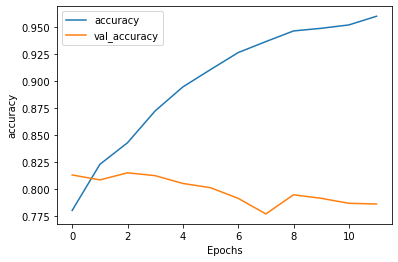

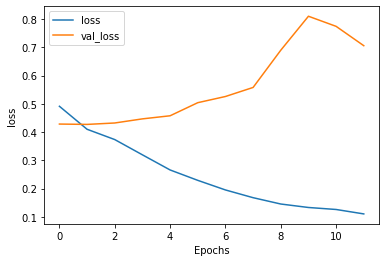

In [223]:
plot_graphs(history7, 'accuracy')
plot_graphs(history7, 'loss')

In [224]:
preds7 = model7.predict_classes(X_test)

In [225]:
metrics_analyze(preds7, y_test)

F1-score:  0.752542372881356
Precision:  0.6666666666666666
Recall:  0.8638132295719845
Acuracy:  0.8082731451083388
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1009
           1       0.67      0.86      0.75       514

    accuracy                           0.81      1523
   macro avg       0.79      0.82      0.80      1523
weighted avg       0.83      0.81      0.81      1523

